### Analysis of FEMA's National Flood Insurance Program (NFIP) Claims Data With DuckDB - In memory Engine
##### Data Source : https://www.fema.gov/openfema-data-page/fima-nfip-redacted-claims-v2

In [1]:
import duckdb
import pandas as pd
import numpy as np

In [ ]:
claims = pd.read_parquet(r'data\FimaNfipClaims.parquet')

In [2]:
con = duckdb.connect('data\insurance.duckdb')

In [ ]:
# con.sql("""
#         CREATE TABLE claims
#         as from read_parquet('data\FimaNfipClaims.parquet')
#         """)

OutOfMemoryException: Out of Memory Error: Allocation failure

In [3]:
con.sql("""
        SELECT * FROM claims 
        limit 3
        """), con.sql("""
        SELECT count(claims) 
        FROM claims 
        """)

(┌───────────────────────────────┬──────────────────────────┬─────────────────────────────────┬─────────────┬───────────────────────┬────────────┬───────────────────────────┬───────────────────────────────┬─────────────────────┬────────────────────┬────────────────┬──────────────┬────────────────────┬─────────────────────┬──────────────────────┬────────────────────────────────────┬────────────────────┬─────────────────┬───────────────┬──────────────────────────┬────────────────┬───────────────────────────┬───────────────────────────┬────────────────────────────────────────────┬───────────────────────────────┬──────────────┬────────────────────────────────┬────────────────────────────────┬────────────────────────────────┬────────────┬───────────────────────────┬──────────────────────┬────────────────────────┬──────────────────────────┬───────────────────────┬───────────────┬─────────────────────────────┬──────────────────────┬────────────────────────┬──────────────────────────┬─────────

In [6]:
# con.sql("""
#         SELECT string_agg(column_name, ', ')
#         FROM information_schema.columns
#         where table_name = 'claims'
#         """)
############## OR ##############
con.sql("""
        select column_name
        from
        (describe claims)
        """).df().column_name.values
### To comfortably view columns without needing to slide, use pandas dataframe


array(['agricultureStructureIndicator', 'asOfDate',
       'basementEnclosureCrawlspaceType', 'policyCount',
       'crsClassificationCode', 'dateOfLoss', 'elevatedBuildingIndicator',
       'elevationCertificateIndicator', 'elevationDifference',
       'baseFloodElevation', 'ratedFloodZone', 'houseWorship',
       'locationOfContents', 'lowestAdjacentGrade',
       'lowestFloorElevation', 'numberOfFloorsInTheInsuredBuilding',
       'nonProfitIndicator', 'obstructionType', 'occupancyType',
       'originalConstructionDate', 'originalNBDate',
       'amountPaidOnBuildingClaim', 'amountPaidOnContentsClaim',
       'amountPaidOnIncreasedCostOfComplianceClaim',
       'postFIRMConstructionIndicator', 'rateMethod',
       'smallBusinessIndicatorBuilding', 'totalBuildingInsuranceCoverage',
       'totalContentsInsuranceCoverage', 'yearOfLoss',
       'primaryResidenceIndicator', 'buildingDamageAmount',
       'buildingDeductibleCode', 'netBuildingPaymentAmount',
       'buildingPropertyValu

In [4]:
con.sql("""
        select count(crsClassificationCode), crsClassificationCode
        from claims
        group by crsClassificationCode
        """), 
con.sql("""
        select 
        count(ratedFloodZone), 
        round(count(ratedFloodZone)*100/(select count(*) from claims),5) as percent,
        sum(amountPaidOnBuildingClaim) + 
        sum(amountPaidOnContentsClaim) + 
        sum(amountPaidOnIncreasedCostOfComplianceClaim) as total_claim_amount,
        total_claim_amount*100/(select sum(amountPaidOnBuildingClaim) + 
        sum(amountPaidOnContentsClaim) + 
        sum(amountPaidOnIncreasedCostOfComplianceClaim) from claims) as percent_of_total_amount,
        ratedFloodZone
        from claims
        group by ratedFloodZone
        having ratedFloodZone in ('VE', 'AE', 'A', 'AO', 'AH', 'AR')
        order by count(ratedFloodZone) desc
        """)
# AE, A1-A30 =  Special Flood with Base Flood Elevation on FIRM
# Flood zones with High risk = VE, AE, A, AO, AH, AR

┌───────────────────────┬──────────┬────────────────────┬─────────────────────────┬────────────────┐
│ count(ratedFloodZone) │ percent  │ total_claim_amount │ percent_of_total_amount │ ratedFloodZone │
│         int64         │  double  │   decimal(38,2)    │         double          │    varchar     │
├───────────────────────┼──────────┼────────────────────┼─────────────────────────┼────────────────┤
│                934394 │ 34.45064 │     42224109737.44 │       47.90256155692094 │ AE             │
│                201023 │  7.41162 │      3245027248.65 │      3.6814303131300763 │ A              │
│                 47839 │   1.7638 │      1941278587.58 │       2.202348791222176 │ VE             │
│                 16816 │     0.62 │       469845984.14 │      0.5330325806154703 │ AO             │
│                 16505 │  0.60853 │       487391921.48 │      0.5529381594122676 │ AH             │
│                    93 │  0.00343 │         1805679.14 │   0.0020485134368434473 │ AR     

In [5]:
con.sql("""
        select count(causeOfDamage), 
        causeOfDamage, 
        avg(floodWaterDuration),
        sum(amountPaidOnBuildingClaim) + 
        sum(amountPaidOnContentsClaim) + 
        sum(amountPaidOnIncreasedCostOfComplianceClaim) as total_claim_amount
        from claims
        group by causeOfDamage
        order by count(causeOfDamage) desc
        """)

┌──────────────────────┬───────────────┬─────────────────────────┬────────────────────┐
│ count(causeOfDamage) │ causeOfDamage │ avg(floodWaterDuration) │ total_claim_amount │
│        int64         │    varchar    │         double          │   decimal(38,2)    │
├──────────────────────┼───────────────┼─────────────────────────┼────────────────────┤
│              1199128 │ 4             │      0.2054109359714639 │     35559113208.10 │
│               685878 │ 1             │     0.20208062757776687 │     24635319012.14 │
│               543815 │ 2             │      3.1868447751099085 │     19036212446.71 │
│               207339 │ 0             │    0.039670549792415036 │      6335682478.42 │
│                15809 │ B             │                     0.0 │      2101842423.68 │
│                13137 │ 3             │       0.654490106544901 │       271516270.47 │
│                 5531 │ D             │                     0.0 │        17644844.66 │
│                 1777 │ 9      

In [6]:
con.sql("""
        select count(policycount), avg(waterdepth - lowestFloorElevation) as flood_Depth,
        max(reportedzipcode),
        floodEvent
        from claims
        where waterdepth - lowestFloorElevation>0 and 
        left(floodevent,9) = 'Hurricane'
        group by floodevent
        order by  count(policycount) desc
        """)

┌────────────────────┬────────────────────┬──────────────────────┬───────────────────────────────┐
│ count(policycount) │    flood_Depth     │ max(reportedzipcode) │          floodEvent           │
│       int64        │       double       │       varchar        │            varchar            │
├────────────────────┼────────────────────┼──────────────────────┼───────────────────────────────┤
│              48902 │ 15.172999059343176 │ 71291                │ Hurricane Katrina             │
│               9452 │  18.68922979263648 │ 87352                │ Hurricane Sandy               │
│               3941 │   33.5217203755392 │ 78759                │ Hurricane Ike                 │
│               3151 │ 50.217296096477305 │ 34771                │ Hurricane Ian                 │
│               2164 │ 20.820748613678372 │ 70817                │ Hurricane Isaac               │
│               1645 │  38.91872340425532 │ 70140                │ Hurricane Ivan                │
│         

In [7]:
con.sql("""
        alter table claims 
        add column flood_depth_over_floor float
        """)
con.sql("""
        update claims
        set flood_depth_over_floor = waterdepth - lowestFloorElevation
        """)

<AxesSubplot: xlabel='year'>

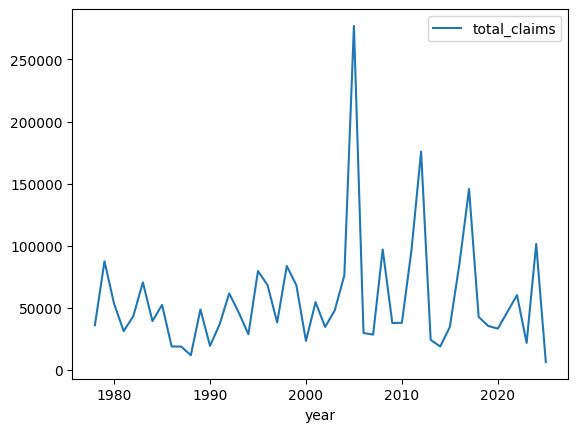

In [11]:
con.sql("""
        select count(*) as total_claims, year(dateOfLoss) as year
        from claims
        group by year(dateOfLoss)
        order by year(dateOfLoss)
        """).df().plot(x ="year" , y = 'total_claims')

In [8]:
flood_area = con.sql("""
        Select count(reportedZipCode), 
        left(reportedZipCode,2) as area_code,
        avg(latitude) as lat, avg(longitude) as lon,
        avg(FloodWaterDuration) as flood_retention_hr,
        avg(amountPaidOnBuildingClaim) + 
        avg(amountPaidOnContentsClaim) + 
        avg(amountPaidOnIncreasedCostOfComplianceClaim) as avg_claim_amount,
        count(distinct(yearOfLoss)) as flood_freq_yrs
        from claims
        where flood_depth_over_floor>0
        group by left(reportedZipCode,2)
        order by count(left(reportedZipCode,2)) desc
        """).df()

In [92]:
flood_area

,count(reportedZipCode),area_code,lat,lon,flood_retention_hr,avg_claim_amount,flood_freq_yrs
0,62655,70,29.999596,-90.153176,0.066826,93158.840979,48
1,5296,33,26.342784,-81.678693,0.171190,81142.808174,40
2,4830,08,39.769193,-74.235797,0.018084,65793.154211,34
3,4674,77,29.488806,-94.885830,0.040731,81350.263773,34
4,3942,11,40.658879,-73.537316,0.020683,80294.550362,33
...,...,...,...,...,...,...,...
95,4,86,34.925000,-114.000000,0.000000,18186.230000,3
96,3,42,37.033333,-86.533333,16.000000,26518.100000,3
97,3,49,44.133333,-85.800000,0.000000,1705.480000,2
98,2,81,37.900000,-107.800000,0.000000,7621.130000,1


Text(0.5, 1.0, 'Number of years of flood occurence')

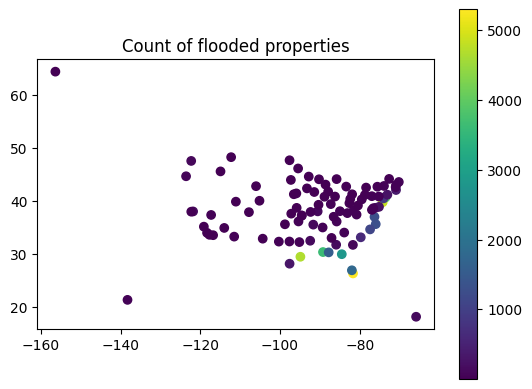

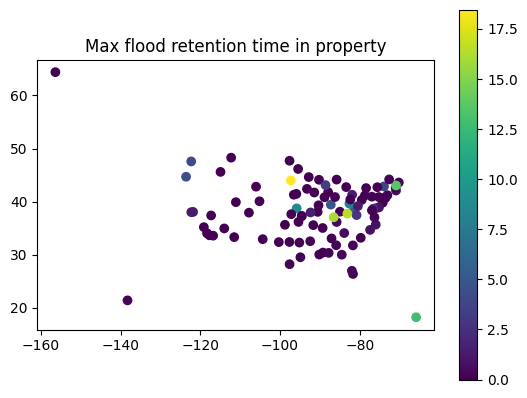

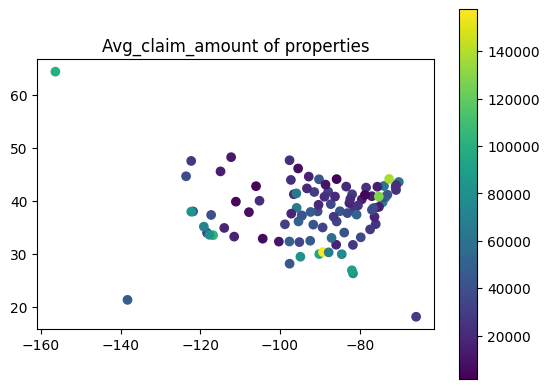

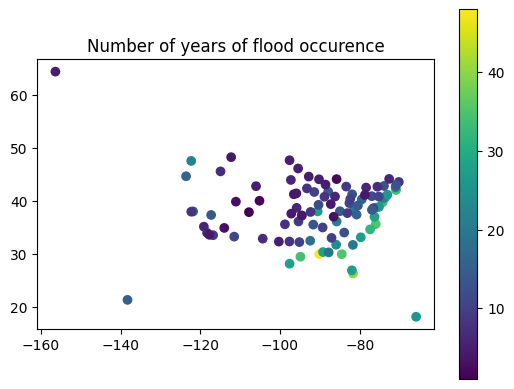

In [9]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 1, figsize=(10, 14))
geometry = gpd.points_from_xy(x = flood_area.dropna()['lon'],y=flood_area.dropna()['lat'])
flood_area_gdf = gpd.GeoDataFrame(flood_area.dropna(), geometry = geometry,crs = "epsg:4326")
flood_area_gdf[1:].plot(column = 'count(reportedZipCode)',legend = True)
plt.title('Count of flooded properties')
flood_area_gdf.plot(column = 'flood_retention_hr',legend = True)
plt.title('Max flood retention time in property')
flood_area_gdf.plot(column = 'avg_claim_amount',legend = True)
plt.title('Avg_claim_amount of properties')
flood_area_gdf.plot(column = 'flood_freq_yrs',legend = True)
plt.title('Number of years of flood occurence')
# ctx.add_basemap(ax= ax,crs=flood_area_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)



In [10]:
#formulate a risk index using these derived attributes
from sklearn.preprocessing import MinMaxScaler
risk_columns = ['count(reportedZipCode)','flood_retention_hr','avg_claim_amount','flood_freq_yrs']
flood_area_gdf[risk_columns] = MinMaxScaler().fit_transform(flood_area_gdf[risk_columns])

In [11]:
flood_area_gdf

,count(reportedZipCode),area_code,lat,lon,flood_retention_hr,avg_claim_amount,flood_freq_yrs,geometry
0,1.000000,70,29.999596,-90.153176,0.003623,0.586336,1.000000,POINT (-90.15318 29.9996)
1,0.084497,33,26.342784,-81.678693,0.009281,0.509298,0.829787,POINT (-81.67869 26.34278)
2,0.077059,08,39.769193,-74.235797,0.000980,0.410886,0.702128,POINT (-74.2358 39.76919)
3,0.074569,77,29.488806,-94.885830,0.002208,0.510628,0.702128,POINT (-94.88583 29.48881)
4,0.062886,11,40.658879,-73.537316,0.001121,0.503859,0.680851,POINT (-73.53732 40.65888)
...,...,...,...,...,...,...,...,...
94,0.000048,51,41.440000,-95.900000,0.000000,0.398847,0.063830,POINT (-95.9 41.44)
95,0.000032,86,34.925000,-114.000000,0.000000,0.105663,0.042553,POINT (-114 34.925)
96,0.000016,42,37.033333,-86.533333,0.867470,0.159082,0.042553,POINT (-86.53333 37.03333)
97,0.000016,49,44.133333,-85.800000,0.000000,0.000000,0.021277,POINT (-85.8 44.13333)


In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit_transform(flood_area_gdf[risk_columns])
print(pca.explained_variance_ratio_)
flood_area_gdf['pca_pc1'] = pca.transform(flood_area_gdf[risk_columns])[:, 0]
flood_area_gdf[[*risk_columns,'pca_pc1']].corr()

[0.44585464]


,count(reportedZipCode),flood_retention_hr,avg_claim_amount,flood_freq_yrs,pca_pc1
count(reportedZipCode),1.000000,-0.056459,0.251314,0.441849,0.512831
flood_retention_hr,-0.056459,1.000000,-0.098285,-0.082555,-0.305518
avg_claim_amount,0.251314,-0.098285,1.000000,0.309343,0.670959
flood_freq_yrs,0.441849,-0.082555,0.309343,1.000000,0.881809
pca_pc1,0.512831,-0.305518,0.670959,0.881809,1.000000


Text(0.5, 1.0, 'Flood Risk Index (PC1) based on PCA')

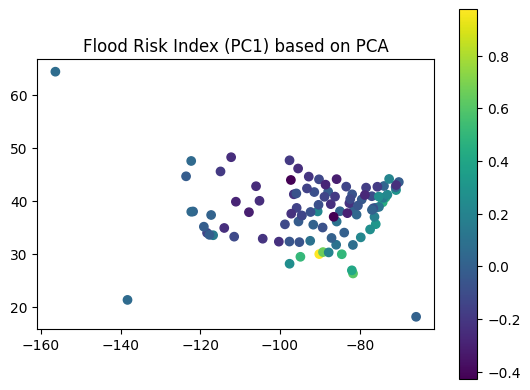

In [ ]:
flood_area_gdf.plot(column = 'pca_pc1',legend=True)
plt.title('Flood Risk Index (PC1) based on PCA')

In [14]:

con.close()